<a href="https://colab.research.google.com/github/shaurya7303/Fraud/blob/main/Fraud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)

** Dataset Loading**

In [2]:
df=pd.read_csv('Fraud.csv')

**Dataset Understanding**


In [3]:
df.shape

(6362620, 11)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [5]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [6]:
df.isnull().sum()

,0
step,0
type,0
amount,0
nameOrig,0
oldbalanceOrg,0
newbalanceOrig,0
nameDest,0
oldbalanceDest,0
newbalanceDest,0
isFraud,0


In [7]:
df['isFraud'].value_counts()

,count
isFraud,
0,6354407
1,8213


In [8]:
fraud_rate = (df['isFraud'].sum() / len(df)) * 100
fraud_rate

np.float64(0.12908204481801522)

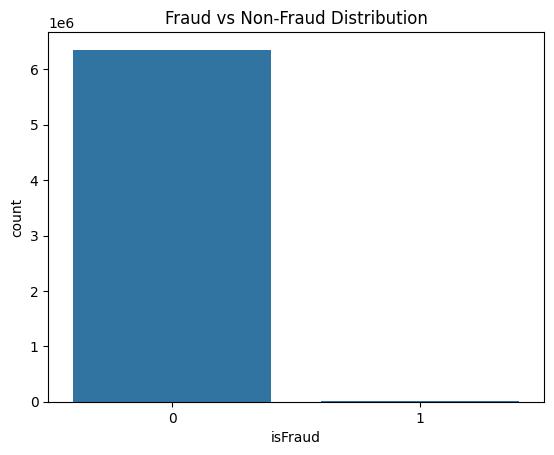

In [9]:
sns.countplot(x='isFraud', data=df)
plt.title("Fraud vs Non-Fraud Distribution")
plt.show()

The fraud rate is very low which is making our accuracy unreliable


**EDA**

In [10]:
pd.crosstab(df['type'], df['isFraud'], normalize='index')

isFraud,0,1
type,,
CASH_IN,1.000000,0.000000
CASH_OUT,0.998160,0.001840
DEBIT,1.000000,0.000000
PAYMENT,1.000000,0.000000
TRANSFER,0.992312,0.007688


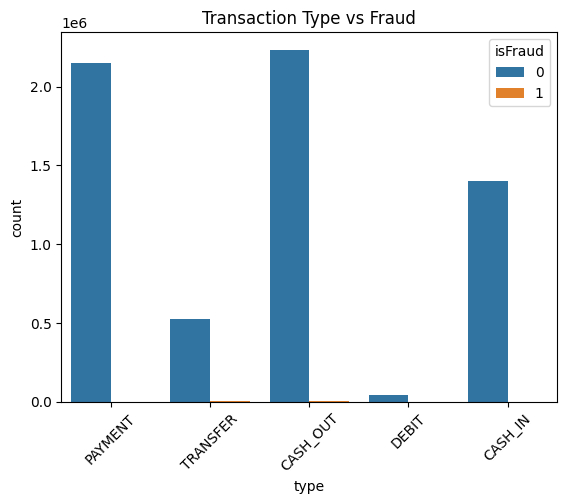

In [11]:
sns.countplot(x='type', hue='isFraud', data=df)
plt.xticks(rotation=45)
plt.title("Transaction Type vs Fraud")
plt.show()

Fraud mainly occur in transfer and cash OUt

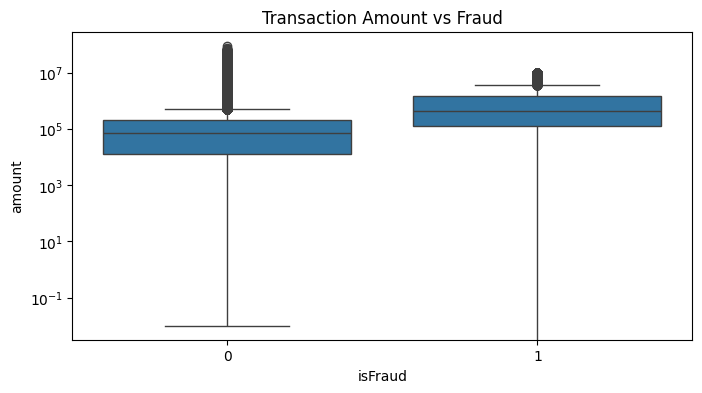

In [12]:
plt.figure(figsize=(8,4))
sns.boxplot(x='isFraud', y='amount', data=df)
plt.yscale('log')
plt.title("Transaction Amount vs Fraud")
plt.show()

this shows that fraud usually occur in large amount

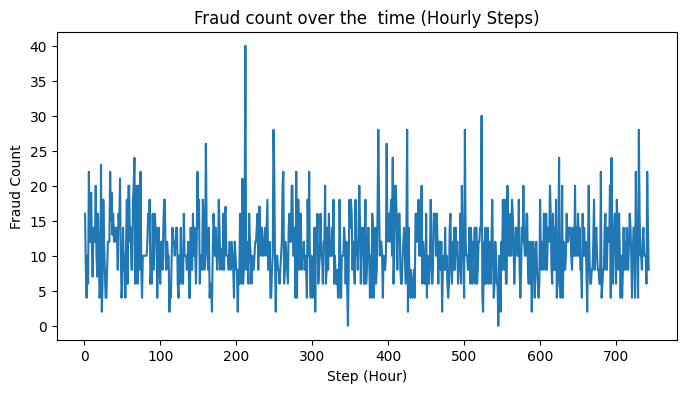

In [13]:
df.groupby('step')['isFraud'].sum().plot(figsize=(8,4))
plt.title("Fraud count over the  time (Hourly Steps)")
plt.xlabel("Step (Hour)")
plt.ylabel("Fraud Count")
plt.show()

It shows that fraud appears in burst and it shows that there is automated frauds activity

***CLEAN***

In [14]:
df.drop(['nameOrig', 'nameDest'], axis=1, inplace=True)
# Have to drop these column cuz they dont give predictive generalization

In [15]:
df.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0,0
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0,0
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,1,0
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0,0


HAndle Missing Data
Now as in data dictionary it said that there is not information for customers that start with M . So we have to handle that missing Data

In [16]:
df['dest_balance_missing'] = (
    (df['oldbalanceDest'] == 0) &
    (df['newbalanceDest'] == 0)
).astype(int)

In [17]:
df['orig_account_emptied'] = (
    (df['oldbalanceOrg'] > 0) &
    (df['newbalanceOrig'] == 0)
).astype(int)

In [18]:
pd.crosstab(df['dest_balance_missing'], df['isFraud'], normalize='index')
#The transactions with missing destination balances have higher fraud rate.

isFraud,0,1
dest_balance_missing,,
0,0.998977,0.001023
1,0.998241,0.001759


In [19]:
df.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,dest_balance_missing,orig_account_emptied
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0,0,1,0
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0,0,1,0
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,1,0,1,1
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1,0,0,1
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0,0,1,0


**Feature Engg**

In [20]:
df['orig_balance_change'] = df['oldbalanceOrg'] - df['newbalanceOrig']
df['dest_balance_change'] = df['newbalanceDest'] - df['oldbalanceDest']

In [21]:
df['large_transaction'] = (df['amount'] > 200000).astype(int)

df['balance_mismatch'] = (
    (df['oldbalanceOrg'] - df['amount']) != df['newbalanceOrig']
).astype(int)

In [22]:
df.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,dest_balance_missing,orig_account_emptied,orig_balance_change,dest_balance_change,large_transaction,balance_mismatch
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0,0,1,0,9839.64,0.0,0,0
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0,0,1,0,1864.28,0.0,0,0
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,1,0,1,1,181.00,0.0,0,0
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1,0,0,1,181.00,-21182.0,0,0
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0,0,1,0,11668.14,0.0,0,0


The acoounts are frequently emptied in a single transaction and also fraud transactions voilate balnce conservation

Encoding

In [23]:
le = LabelEncoder()
df['type_encoded'] = le.fit_transform(df['type'])
df.drop('type', axis=1, inplace=True)

In [24]:
df.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,dest_balance_missing,orig_account_emptied,orig_balance_change,dest_balance_change,large_transaction,balance_mismatch,type_encoded
0,1,9839.64,170136.0,160296.36,0.0,0.0,0,0,1,0,9839.64,0.0,0,0,3
1,1,1864.28,21249.0,19384.72,0.0,0.0,0,0,1,0,1864.28,0.0,0,0,3
2,1,181.00,181.0,0.00,0.0,0.0,1,0,1,1,181.00,0.0,0,0,4
3,1,181.00,181.0,0.00,21182.0,0.0,1,0,0,1,181.00,-21182.0,0,0,1
4,1,11668.14,41554.0,29885.86,0.0,0.0,0,0,1,0,11668.14,0.0,0,0,3


**Spliting and Model training**

In [25]:
X = df.drop('isFraud', axis=1)
y = df['isFraud']

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,stratify=y, random_state=42)

In [27]:
lr = LogisticRegression(max_iter=1000,class_weight='balanced')
lr.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [28]:
y_predlr = lr.predict(X_test)
y_problr = lr.predict_proba(X_test)[:,1]

In [29]:
print(classification_report(y_test, y_predlr))
print("ROC-AUC-", roc_auc_score(y_test, y_problr))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.68      1.00      0.81      1643

    accuracy                           1.00   1272524
   macro avg       0.84      1.00      0.90   1272524
weighted avg       1.00      1.00      1.00   1272524

ROC-AUC- 0.998321717659341


In [30]:
scaleposweight = y_train.value_counts()[0] / y_train.value_counts()[1]
scaleposweight

np.float64(773.7482496194825)

In [31]:
xgb = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scaleposweight,
    eval_metric='logloss',
    random_state=42
)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

In [32]:
y_predxgb = xgb.predict(X_test)
y_probxgb = xgb.predict_proba(X_test)[:,1]

In [33]:
print(classification_report(y_test, y_predxgb))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       1.00      1.00      1.00      1643

    accuracy                           1.00   1272524
   macro avg       1.00      1.00      1.00   1272524
weighted avg       1.00      1.00      1.00   1272524



As we can we have a perfict clssification , this is expected due to synthetic and this rule based dataset ,, the fraud patterns are deterministic and have noises .

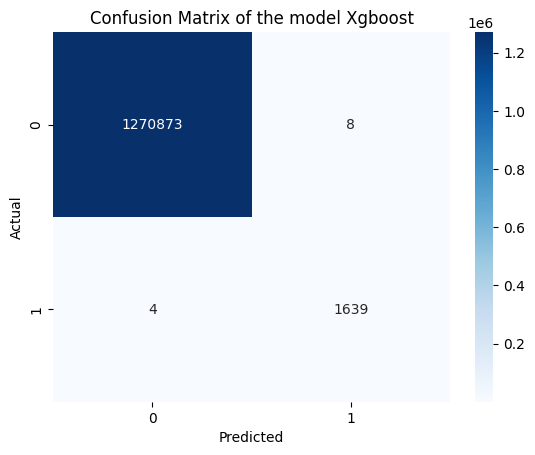

In [34]:
cm = confusion_matrix(y_test, y_predxgb)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix of the model Xgboost")
plt.show()

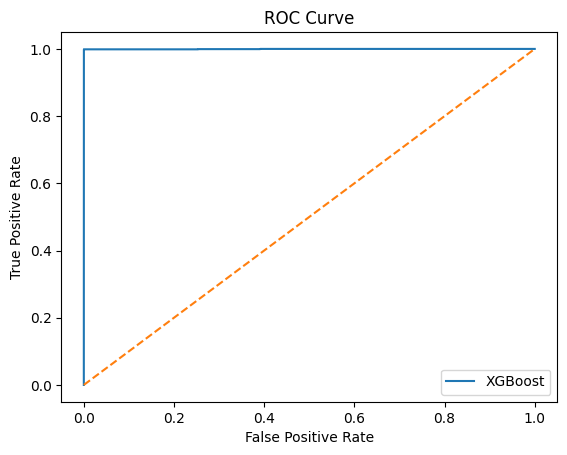

In [35]:
fpr, tpr, _ = roc_curve(y_test, y_probxgb)
plt.plot(fpr, tpr, label="XGBoost")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.title("ROC Curve")
plt.show()

In [36]:
importance = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb.feature_importances_
}).sort_values(by='importance', ascending=False)

importance.head(10)

,feature,importance
12,balance_mismatch,0.356158
3,newbalanceOrig,0.240777
9,orig_balance_change,0.217222
8,orig_account_emptied,0.059091
7,dest_balance_missing,0.056361
13,type_encoded,0.021927
1,amount,0.019106
6,isFlaggedFraud,0.012728
2,oldbalanceOrg,0.006766
10,dest_balance_change,0.003303


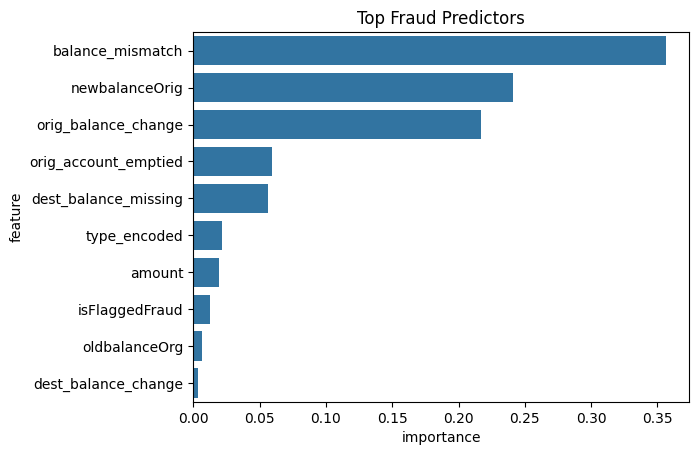

In [37]:
sns.barplot(x='importance', y='feature', data=importance.head(10))
plt.title("Top Fraud Predictors")
plt.show()

In [43]:
importance= pd.DataFrame({
    'feature': X.columns,
    'importance': xgb.feature_importances_
}).sort_values(by='importance', ascending=False)

imp.head(10)

,feature,importance
12,balance_mismatch,0.356158
3,newbalanceOrig,0.240777
9,orig_balance_change,0.217222
8,orig_account_emptied,0.059091
7,dest_balance_missing,0.056361
13,type_encoded,0.021927
1,amount,0.019106
6,isFlaggedFraud,0.012728
2,oldbalanceOrg,0.006766
10,dest_balance_change,0.003303


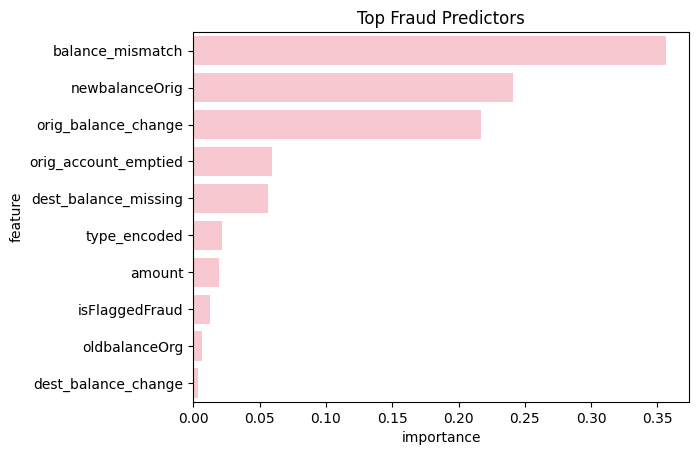

In [44]:
sns.barplot(x='importance', y='feature', data=importance.head(10), color='pink')
plt.title("Top Fraud Predictors")
plt.show()

The Frauder aim is to drain ur account quickly , they even tranfers funds to newly accounts (merchants)          # large transfers are higher risk                                     # all these factors are consistent with real world financial fraud behavior

**Prevention Measures During Infrastructure Update**

# Multiple transactions in short time                             # temporary tansactions delay for suspicious transfers           # real time ml based transaction risk scoring

***The solution is balances bussiness judgement , it not just demonstrate the fraud model but also hoe to monitor and improve it in a real financial system   ***       